OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August, September 2022

**Context** :

**Objective** : predict CO2 and Total Energy

NB : The prediction of CO2 will be based solely on the building's structural data (building type, year built, geographical position...)


1) Exploratory data analysis.
2) Try different machine models

#### Features to predict :

##### Energy Use :

- **SiteEnergyUse(kBtu)** : The annual amount of energy consumed by the property from all sources of energy.

- **SteamUse(kBtu)** : The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).

- **Electricity(kBtu)** : The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu).

- **NaturalGas(kBtu)** : The annual amount of utility-supplied natural gas consumed by the property, measured in thousands of British thermal units (kBtu).

##### Greenhouse Gas Emissions :

- **TotalGHGEmissions** : The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.


# PART 1 : Cleaning dataset

### Importing libraries

In [1]:
%reset -f

from cleaning import *

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action="once")

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [2]:
# Starting time
t0 = time()

### 1) Visualizing dataset

#### Loading dataset

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# load raw dataset
input_path = "./dataset/source/"
input_filename = "2016_Building_Energy_Benchmarking.csv"

raw_dataset_file = "{}{}".format(input_path, input_filename)

raw_data = pd.read_csv(raw_dataset_file)

display(raw_data)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.00,0659000030,7,DOWNTOWN,47.61,-122.34,1927,1.00,12,88434,0,88434,Hotel,Hotel,88434.00,NaN,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.00,0659000220,7,DOWNTOWN,47.61,-122.33,1996,1.00,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,NaN,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.00,0659000475,7,DOWNTOWN,47.61,-122.34,1969,1.00,41,956110,196718,759392,Hotel,Hotel,756493.00,NaN,NaN,NaN,NaN,NaN,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.00,0659000640,7,DOWNTOWN,47.61,-122.34,1926,1.00,10,61320,0,61320,Hotel,Hotel,61320.00,NaN,NaN,NaN,NaN,NaN,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.00,0659000970,7,DOWNTOWN,47.61,-122.34,1980,1.00,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,NaN,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.57,-122.31,1990,1.00,1,12294,0,12294,Office,Office,12294.00,NaN,NaN,NaN,NaN,NaN,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.60,-122.32,2004,1.00,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.00,NaN,NaN,NaN,NaN,NaN,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.64,-122.36,1974,1.00,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Cen

#### 1) Global statistics

What's in this Dataset?
Rows : 3,376
Columns : 46
Each row is a : Building



source : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

In [4]:
print("Primary Key : OSEBuilding ID")
raw_data["OSEBuildingID"].unique().shape

Primary Key : OSEBuilding ID


(3376,)

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

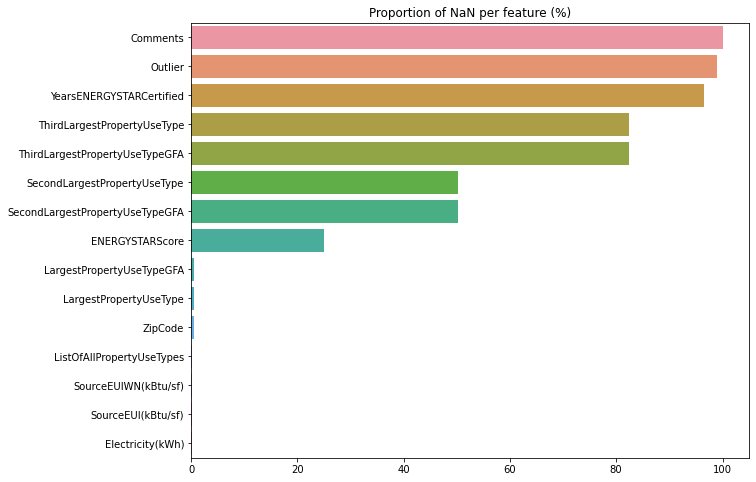

In [6]:
display_barplot_na(raw_data, number_features=15)

In [7]:
raw_data.describe().transpose().sort_values(by="min", ascending=True)

,count,mean,std,min,25%,50%,75%,max
Electricity(kBtu),3367.00,3707612.16,14850656.14,-115417.00,639487.00,1177583.00,2829632.50,657074389.00
Electricity(kWh),3367.00,1086638.97,4352478.36,-33826.80,187422.95,345129.91,829317.84,192577488.00
Longitude,3376.00,-122.33,0.03,-122.41,-122.35,-122.33,-122.32,-122.22
SourceEUIWN(kBtu/sf),3367.00,137.78,139.11,-2.10,78.40,101.10,148.35,2620.00
TotalGHGEmissions,3367.00,119.72,538.83,-0.80,9.50,33.92,93.94,16870.98
GHGEmissionsIntensity,3367.00,1.18,1.82,-0.02,0.21,0.61,1.37,34.09
NaturalGas(kBtu),3367.00,1368504.54,6709780.83,0.00,0.00,323754.00,1189033.50,297909000.00
NaturalGas(therms),3367.00,13685.05,67097.81,0.00,0.00,3237.54,11890.33,2979090.00
SteamUse(kBtu),3367.00,274595.90,3912173.39,0.00,0.00,0.00,0.00,134943456.00
SiteEnergyUseWN(kBtu),3370.00,5276725.71,15938786.48,0.00,970182.23,1904452.00,4381429.12,471613856.00


In [8]:
print("We have some missing values, we also have negative values for energy variables and some categories are presented as numerical objects.")

We have some missing values, we also have negative values for energy variables and some categories are presented as numerical objects.


#### 2) Categorical features describing the buildings

In [9]:
raw_data.select_dtypes(exclude='number').nunique().sort_values(ascending=True)

City                                1
State                               1
DefaultData                         2
Outlier                             2
ComplianceStatus                    4
BuildingType                        8
Neighborhood                       19
PrimaryPropertyType                24
ThirdLargestPropertyUseType        44
SecondLargestPropertyUseType       50
LargestPropertyUseType             56
YearsENERGYSTARCertified           65
ListOfAllPropertyUseTypes         466
TaxParcelIdentificationNumber    3268
Address                          3354
PropertyName                     3362
dtype: int64

In [10]:
building_type_features = ["BuildingType", "PrimaryPropertyType", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "ListOfAllPropertyUseTypes"]

In [11]:
#for feature in building_type_features:
for feature in building_type_features[:2]:
    all_values = raw_data[feature].unique().tolist()
    print(all_values, end='\n\n')

print("The list being too long, we didn't print it all.")

['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)', 'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)', 'Multifamily HR (10+)', 'Nonresidential WA']

['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property', 'K-12 School', 'University', 'Small- and Mid-Sized Office', 'Self-Storage Facility', 'Warehouse', 'Large Office', 'Senior Care Community', 'Medical Office', 'Retail Store', 'Hospital', 'Residence Hall', 'Distribution Center', 'Worship Facility', 'Low-Rise Multifamily', 'Supermarket / Grocery Store', 'Laboratory', 'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily', 'Office']

The list being too long, we didn't print it all.


In [12]:
categories_to_check = ["BuildingType", "PrimaryPropertyType"]

for category in categories_to_check:
    print(raw_data[category].value_counts().sort_values())
    print("\n\n")

Nonresidential WA          1
Campus                    24
Nonresidential COS        85
SPS-District K-12         98
Multifamily HR (10+)     110
Multifamily MR (5-9)     580
Multifamily LR (1-4)    1018
NonResidential          1460
Name: BuildingType, dtype: int64



Office                           3
Hospital                        10
Laboratory                      10
Restaurant                      12
Refrigerated Warehouse          12
Residence Hall                  23
University                      25
Self-Storage Facility           28
Medical Office                  39
Supermarket / Grocery Store     40
Senior Care Community           45
Distribution Center             53
Worship Facility                71
Hotel                           77
Retail Store                    91
High-Rise Multifamily          105
Mixed Use Property             133
K-12 School                    139
Large Office                   173
Warehouse                      187
Other                          2

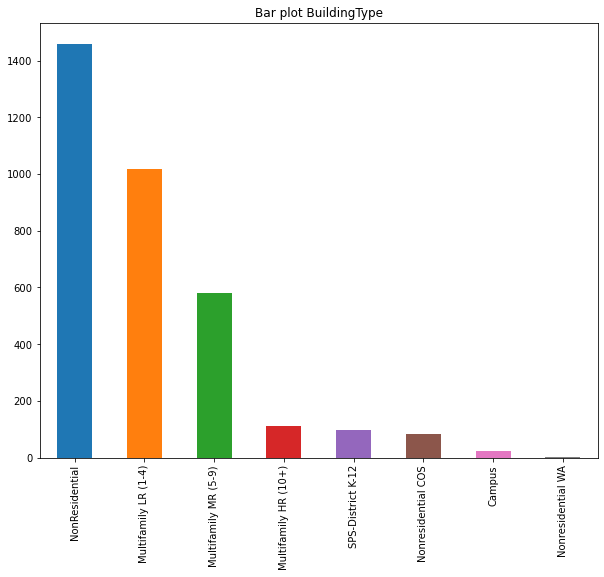

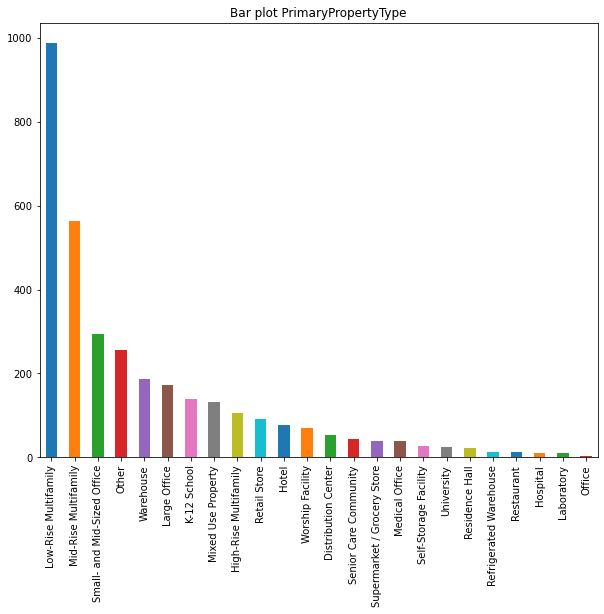

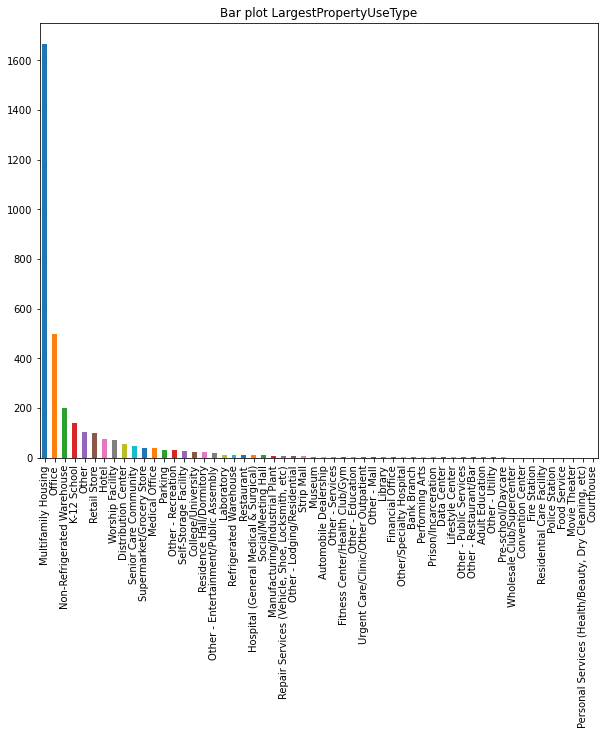

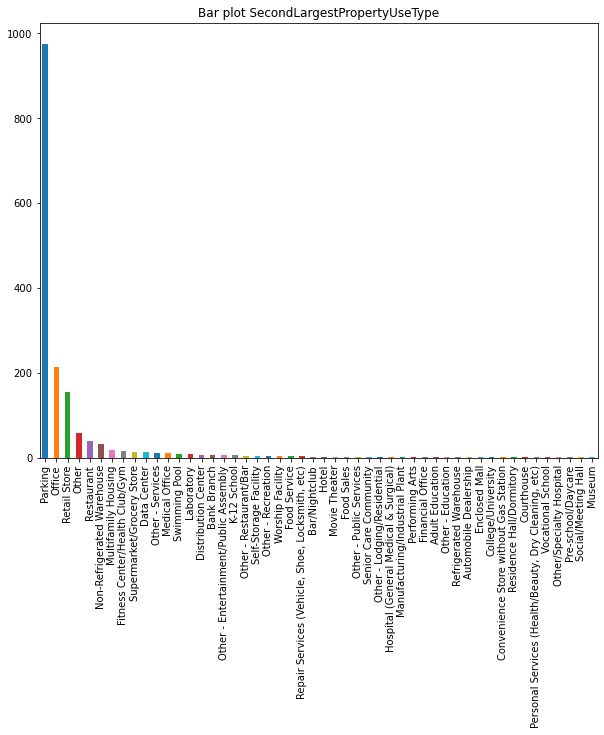

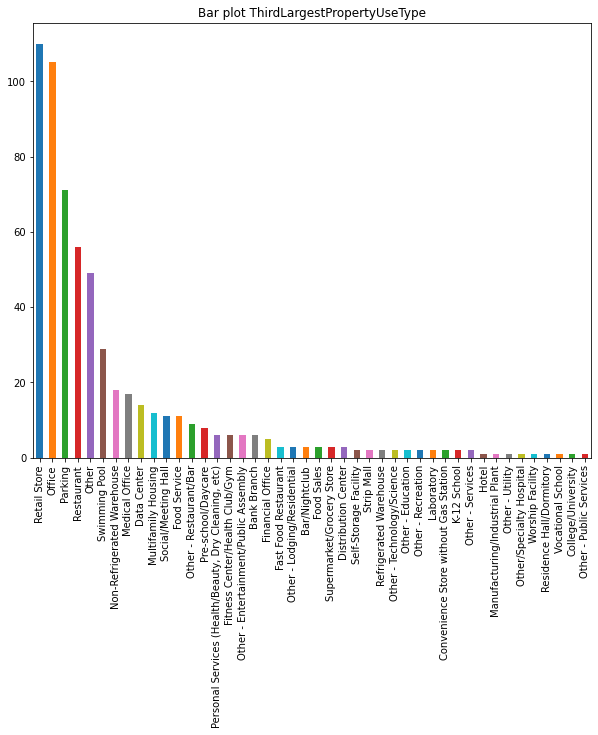

In [13]:
sns_colors = sns.color_palette() # this is so we can have different color per bar

for feature in building_type_features[:5]: # we don't display a bar plot for the features with too many modalities
    plt.figure(figsize=(10, 8))
    plt.title('Bar plot {}'.format(feature))
    raw_data[feature].value_counts().plot(kind="bar", color=sns_colors)

In [14]:
print("For the building type, we only have one building as 'Nonresidential WA', we will map it later.")

For the building type, we only have one building as 'Nonresidential WA', we will map it later.


#### Keeping only non residential buildings

In [15]:
raw_data["BuildingType"].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [16]:
residential_BuildingType = ["Multifamily MR (5-9)", "Multifamily LR (1-4)", "Multifamily HR (10+)"]

print("We check the PrimaryPropertyType for the buildings which type is Residential.")

all_residential_buildings = raw_data[categories_to_check][raw_data["BuildingType"].isin(residential_BuildingType)]

unique_residential_buildings = all_residential_buildings.drop_duplicates()
display(unique_residential_buildings)

We check the PrimaryPropertyType for the buildings which type is Residential.


,BuildingType,PrimaryPropertyType
9,Multifamily MR (5-9),Mid-Rise Multifamily
188,Multifamily LR (1-4),Low-Rise Multifamily
503,Multifamily HR (10+),High-Rise Multifamily
646,Multifamily LR (1-4),Senior Care Community
662,Multifamily LR (1-4),Mixed Use Property
760,Multifamily LR (1-4),Other
876,Multifamily HR (10+),Other
996,Multifamily MR (5-9),Mixed Use Property
1076,Multifamily LR (1-4),Small- and Mid-Sized Office
1153,Multifamily HR (10+),Senior Care Community


In [17]:
data_v0 = remove_residential_buildings(raw_data)
display(data_v0)

___Removing residential buildings___
Before : (3376, 46)
Before cleaning :
Nonresidential WA          1
Campus                    24
Nonresidential COS        85
SPS-District K-12         98
Multifamily HR (10+)     110
Multifamily MR (5-9)     580
Multifamily LR (1-4)    1018
NonResidential          1460
Name: BuildingType, dtype: int64



Office                           3
Hospital                        10
Laboratory                      10
Restaurant                      12
Refrigerated Warehouse          12
Residence Hall                  23
University                      25
Self-Storage Facility           28
Medical Office                  39
Supermarket / Grocery Store     40
Senior Care Community           45
Distribution Center             53
Worship Facility                71
Hotel                           77
Retail Store                    91
High-Rise Multifamily          105
Mixed Use Property             133
K-12 School                    139
Large Office               

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.00,0659000030,7,DOWNTOWN,47.61,-122.34,1927,1.00,12,88434,0,88434,Hotel,Hotel,88434.00,NaN,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.00,0659000220,7,DOWNTOWN,47.61,-122.33,1996,1.00,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,NaN,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.00,0659000475,7,DOWNTOWN,47.61,-122.34,1969,1.00,41,956110,196718,759392,Hotel,Hotel,756493.00,NaN,NaN,NaN,NaN,NaN,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.00,0659000640,7,DOWNTOWN,47.61,-122.34,1926,1.00,10,61320,0,61320,Hotel,Hotel,61320.00,NaN,NaN,NaN,NaN,NaN,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.00,0659000970,7,DOWNTOWN,47.61,-122.34,1980,1.00,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,NaN,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.57,-122.31,1990,1.00,1,12294,0,12294,Office,Office,12294.00,NaN,NaN,NaN,NaN,NaN,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.60,-122.32,2004,1.00,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.00,NaN,NaN,NaN,NaN,NaN,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.64,-122.36,1974,1.00,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Cen

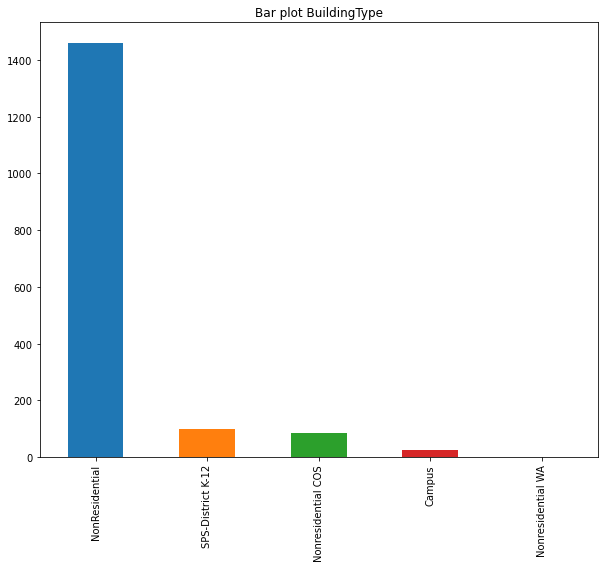

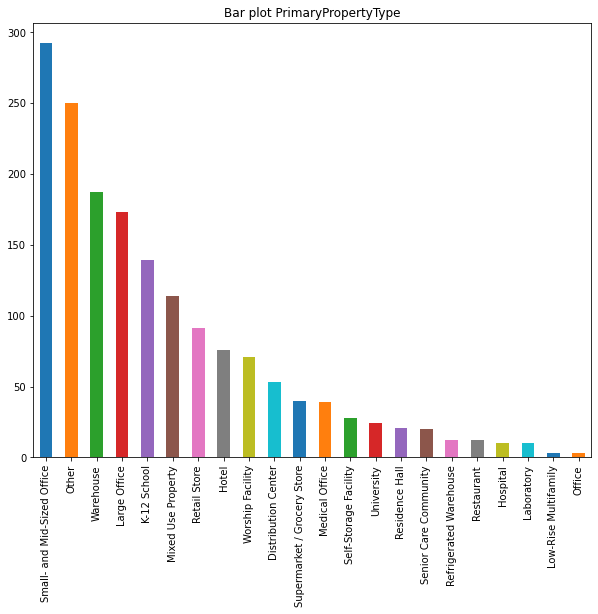

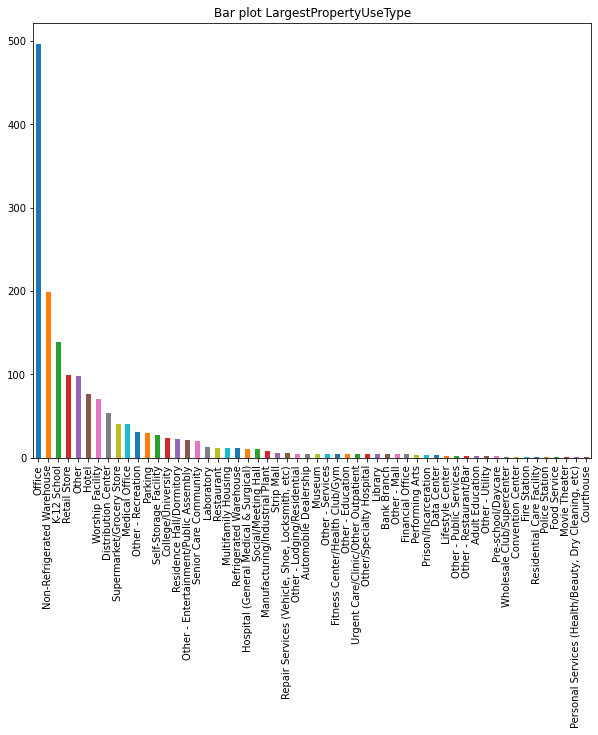

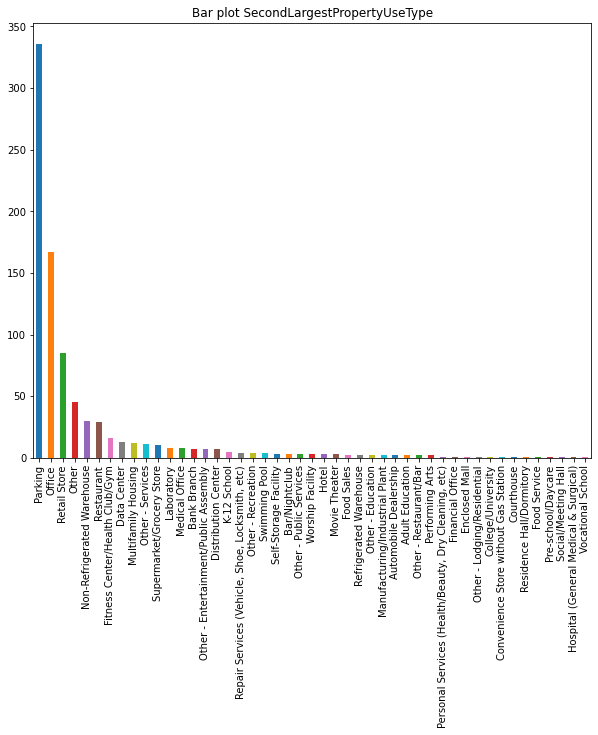

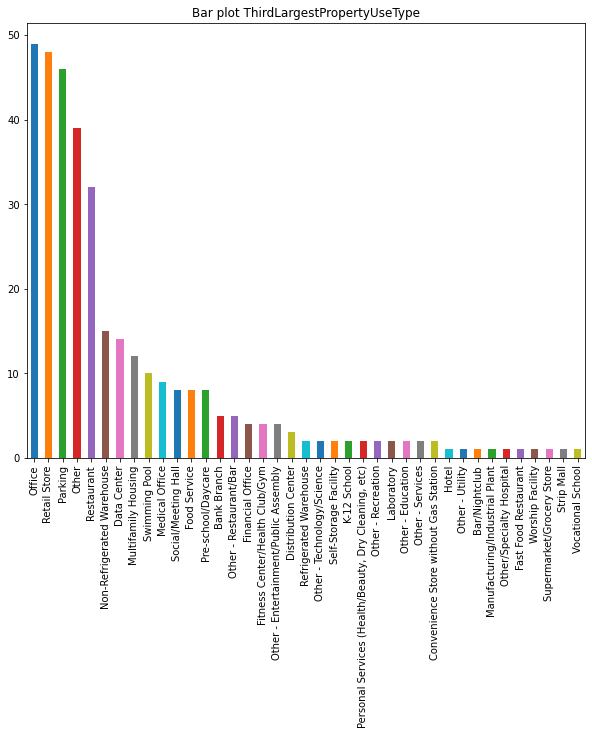

In [18]:
sns_colors = sns.color_palette() # this is so we can have different color per bar

for feature in building_type_features[:5]: # we don't display a bar plot for the features with too many modalities
    plt.figure(figsize=(10, 8))
    plt.title('Bar plot {}'.format(feature))
    data_v0[feature].value_counts().plot(kind="bar", color=sns_colors)

##### Correcting NumberofBuildings

In [19]:
print("This is a correction that was tried to improve the modelling, but is not necessary.")

This is a correction that was tried to improve the modelling, but is not necessary.


In [20]:
data_v0[data_v0['NumberofBuildings'] == 0][["BuildingType", "PrimaryPropertyType", "LargestPropertyUseType"]]

,BuildingType,PrimaryPropertyType,LargestPropertyUseType
63,NonResidential,Medical Office,Medical Office
76,NonResidential,Small- and Mid-Sized Office,Office
160,NonResidential,Warehouse,Non-Refrigerated Warehouse
201,NonResidential,Large Office,Office
241,NonResidential,Small- and Mid-Sized Office,Office
264,NonResidential,Mixed Use Property,Non-Refrigerated Warehouse
278,NonResidential,Large Office,Office
280,NonResidential,Hotel,Hotel
291,NonResidential,Other,Parking
358,Nonresidential COS,Other,Other - Services


#### 4) Geographical features

In [21]:
#categorical_features = raw_data.select_dtypes('object').columns
geo_features = ["City","State", "Address", "CouncilDistrictCode", "Neighborhood", "Latitude", "Longitude", "ZipCode"]
raw_data[geo_features].nunique().sort_values()

City                      1
State                     1
CouncilDistrictCode       7
Neighborhood             19
ZipCode                  55
Longitude              2656
Latitude               2876
Address                3354
dtype: int64

In [22]:
neighborhood_list = raw_data["Neighborhood"].unique().tolist()
print(len(neighborhood_list))
print(neighborhood_list)

neighborhood_list_lower = [e.lower() for e in neighborhood_list]
neighborhood_list_lower = list(set(neighborhood_list_lower))

print(len(neighborhood_list_lower))
print(neighborhood_list_lower)

19
['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'Central', 'NORTH', 'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH', 'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE', 'Ballard', 'North', 'Delridge', 'Northwest', 'DELRIDGE NEIGHBORHOODS']
14
['downtown', 'north', 'east', 'lake union', 'delridge', 'ballard', 'magnolia / queen anne', 'central', 'greater duwamish', 'delridge neighborhoods', 'southeast', 'northeast', 'northwest', 'southwest']


19 unique neighborhoods, but because of upper case / lower case we get 14 neighborhoods.

The buildings are all located in the same city (Seattle).
Geographical information :
- CouncilDistrictCode
- Neighborhood
- Latitude and Longitude
- ZipCode

We will use Neighborhood to localize the buildings.

We will have to map all the strings in our dataset, to have a uniform dataset.

**Conclusion**
We have checked the number of different values each of the features above has.
For example, variables like "City", "State" that only have one value won't help for our modelling, we will drop them.

Columns to drop :
- City : not useful
- State : not useful
- Address : we will use other geographical information
- DefaultData : not useful
- *Outlier : will be dropped since the outliers are Non-Compliant (to see below)*
- YearsENERGYSTARCertified : not useful
- ListOfAllPropertyUSeTypes : too much information, we will prefer using PrimaryPropertyType
- TaxParcelIdentificationNumber : not useful, like an ID
- PropertyName : not useful

### 2) Dropping features

We have 46 columns / features to represent each building.

We select the interesting features that will help us predict the energy consumption of the buildings.

We keep for now **ComplianceStatus** and **Outlier** so that we can remove outlier buildings.

In [23]:
columns_to_drop = ["DataYear", "PropertyName", "ListOfAllPropertyUseTypes", "Address", "City", "State",
                       "TaxParcelIdentificationNumber", "YearsENERGYSTARCertified", "DefaultData",
                       "Comments", "Latitude", "Longitude", "Outlier"]

print("We remove latitude and longitude so that our algorithm won't have too much features. We will localize the buildings based on the Zip Code and the Council District Code.")

We remove latitude and longitude so that our algorithm won't have too much features. We will localize the buildings based on the Zip Code and the Council District Code.


In [24]:
data_v1 = drop_selected_features(data_v0, columns_to_drop)
display(data_v1)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,98101.00,7,DOWNTOWN,1927,1.00,12,88434,0,88434,Hotel,88434.00,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,Compliant,249.98,2.83
1,2,NonResidential,Hotel,98101.00,7,DOWNTOWN,1996,1.00,11,103566,15064,88502,Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,Compliant,295.86,2.86
2,3,NonResidential,Hotel,98101.00,7,DOWNTOWN,1969,1.00,41,956110,196718,759392,Hotel,756493.00,NaN,NaN,NaN,NaN,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,Compliant,2089.28,2.19
3,5,NonResidential,Hotel,98101.00,7,DOWNTOWN,1926,1.00,10,61320,0,61320,Hotel,61320.00,NaN,NaN,NaN,NaN,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,Compliant,286.43,4.67
4,8,NonResidential,Hotel,98121.00,7,DOWNTOWN,1980,1.00,18,175580,62000,113580,Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,Compliant,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,Nonresidential COS,Office,NaN,2,GREATER DUWAMISH,1990,1.00,1,12294,0,12294,Office,12294.00,NaN,NaN,NaN,NaN,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,Error - Correct Default Data,20.94,1.70
3372,50223,Nonresidential COS,Other,NaN,2,DOWNTOWN,2004,1.00,1,16000,0,16000,Other - Recreation,16000.00,NaN,NaN,NaN,NaN,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,Compliant,32.17,2.01
3373,50224,Nonresidential COS,Other,NaN,7,MAGNOLIA / QUEEN ANNE,1974,1.00,1,13157,0,13157,Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,Compliant,223.54,16.99
3374,50225,Nonresidential COS,Mixed Use Property,NaN,1,GREATER DUWAMISH,1989,1.00,1,14101,0,14101,Other - Recreation,6601.00,Fitness Center/Health Club/Gym,6501.00,Pre-school/Daycare,484.00,NaN,51.00,55.50,105.30,110.80,719471.19,782841.31,0.00,102248.00,348870.18,3706.01,370601.00,Compliant,22.11,1.57


### 3) Compliance Status described in the dataset


Below, we will just show that the colum "Outlier" represented 32 buildings that were Non-Compliant.
This is why we dropped the column Outlier above.

In [25]:
outliers_buildings = raw_data[~raw_data["Outlier"].isna()]

outliers_buildings[["Outlier", "ComplianceStatus"]]

,Outlier,ComplianceStatus
226,High outlier,Non-Compliant
384,Low outlier,Non-Compliant
448,Low outlier,Non-Compliant
517,High outlier,Non-Compliant
720,Low outlier,Non-Compliant
834,Low outlier,Non-Compliant
839,Low outlier,Error - Correct Default Data
962,Low outlier,Non-Compliant
1045,Low outlier,Error - Correct Default Data
1229,Low outlier,Non-Compliant


This is an histogram that presents the distribution of the values of the variable ComplianceStatus in %.


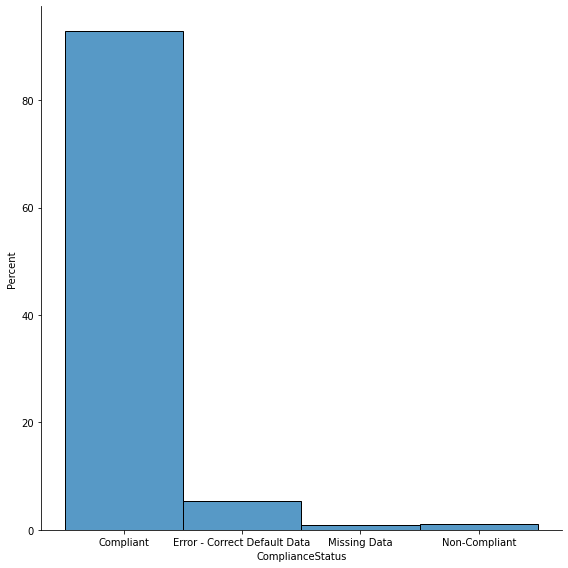

In [26]:
print("This is an histogram that presents the distribution of the values of the variable ComplianceStatus in %.")
sns.displot(data=data_v1, x="ComplianceStatus", stat='percent', height=8, aspect=1) # aspect : to make it wider

This is an histogram that presents the distribution of the values of the variable ComplianceStatus by counting them.


<AxesSubplot:xlabel='ComplianceStatus', ylabel='count'>

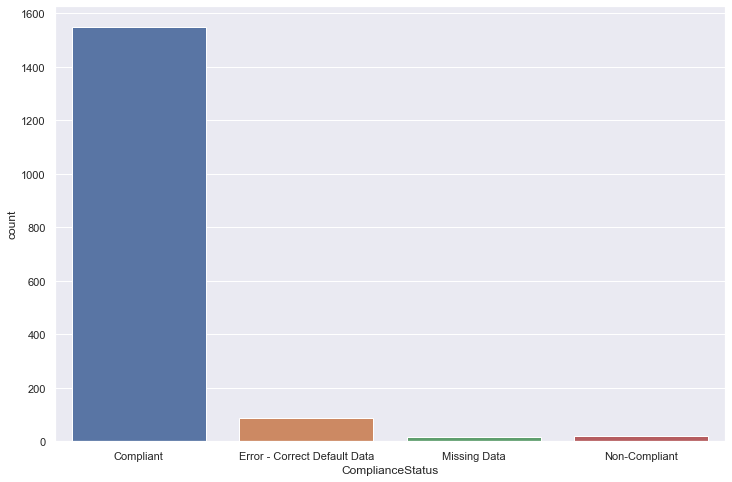

In [27]:
print("This is an histogram that presents the distribution of the values of the variable ComplianceStatus by counting them.")
# to make the graphs bigger
sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(data=data_v1, x="ComplianceStatus") # countnplot is for discrete variable / categories here.

In [28]:
print("Checking ComplianceStatus.")
display(data_v1["ComplianceStatus"].unique())

non_compliant_status = ['Error - Correct Default Data', 'Missing Data', 'Non-Compliant']

non_compliant_buildings = data_v1[data_v1["ComplianceStatus"].isin(non_compliant_status)]
display(non_compliant_buildings)

print("In the raw dataset, we had :", data_v1[data_v1["ComplianceStatus"].isin(non_compliant_status)].shape[0], "non compliant buildings.")

Checking ComplianceStatus.


array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
22,28,SPS-District K-12,K-12 School,98118.00,2,SOUTHEAST,1961,1.00,2,56228,0,56228,K-12 School,58916.00,NaN,NaN,NaN,NaN,95.00,26.10,29.10,60.70,64.60,1539478.50,1713623.50,0.00,274605.91,936955.00,6025.23,602523.00,Error - Correct Default Data,38.53,0.69
28,34,SPS-District K-12,K-12 School,98112.00,3,Central,1955,1.00,1,126351,0,126351,K-12 School,126351.00,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Missing Data,0.00,0.00
30,36,SPS-District K-12,K-12 School,98125.00,5,NORTH,1949,1.00,2,160645,0,160645,K-12 School,164229.00,NaN,NaN,NaN,NaN,75.00,41.30,47.50,68.10,75.70,6779173.00,7800349.50,0.00,570809.19,1947601.00,48315.72,4831572.00,Error - Correct Default Data,270.18,1.68
31,37,SPS-District K-12,K-12 School,98109.00,7,MAGNOLIA / QUEEN ANNE,1989,1.00,2,51582,0,51582,K-12 School,55166.00,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,438691.69,1496816.00,0.00,0.00,Missing Data,10.43,0.20
38,51,SPS-District K-12,K-12 School,98115.00,4,NORTHEAST,1950,1.00,2,175565,0,175565,K-12 School,182861.00,NaN,NaN,NaN,NaN,88.00,35.00,40.10,55.00,60.40,6399127.50,7329817.50,0.00,468840.50,1599684.00,47994.43,4799443.00,Error - Correct Default Data,266.05,1.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3152,43948,Nonresidential COS,Other,98108.00,2,GREATER DUWAMISH,1906,1.00,2,39212,0,39212,Other,39212.00,NaN,NaN,NaN,NaN,NaN,1.80,1.80,5.80,5.80,72370.40,72370.40,0.00,21210.60,72371.00,0.00,0.00,Non-Compliant,0.50,0.01
3166,49703,SPS-District K-12,K-12 School,98199.00,7,MAGNOLIA / QUEEN ANNE,1952,1.00,1,116101,0,116101,K-12 School,119685.00,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,49936.20,4993620.00,Missing Data,265.21,2.28
3366,50210,Nonresidential COS,Office,NaN,7,MAGNOLIA / QUEEN ANNE,1952,1.00,1,13661,0,13661,Office,13661.00,NaN,NaN,NaN,NaN,75.00,36.80,40.90,115.50,128.40,502667.69,558525.12,0.00,147323.50,502667.78,0.00,0.00,Error - Correct Default Data,3.50,0.26
3369,50220,Nonresidential COS,Office,NaN,2,SOUTHEAST,1960,1.00,1,15398,0,15398,Office,15398.00,NaN,NaN,NaN,NaN,93.00,25.20,26.90,64.10,66.70,387810.00,414172.41,0.00,81341.40,277536.85,1102.73,110273.00,Error - Correct Default Data,7.79,0.51


In the raw dataset, we had : 120 non compliant buildings.


In [29]:
data_v2 = keep_compliant(data_v1)

___Keeping compliant buildings only___
Before : (1668, 33)
We delete the columns ComplianceStatus.
After : (1548, 32)


### 4) Filling Property Use Type

In [30]:
# We use head(10) to only display 10 features that have the most missing values.
data_nan = data_v2.isna().sum().sort_values(ascending=False).head(10)

data_nan

ThirdLargestPropertyUseType        1200
ThirdLargestPropertyUseTypeGFA     1200
SecondLargestPropertyUseType        706
SecondLargestPropertyUseTypeGFA     706
ENERGYSTARScore                     551
ZipCode                              13
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SiteEUIWN(kBtu/sf)                    1
SiteEnergyUseWN(kBtu)                 1
dtype: int64

In [31]:
data_nan.values
data_v2.shape

(1548, 32)

<AxesSubplot:title={'center':'Proportion of NaN per feature (%)'}>

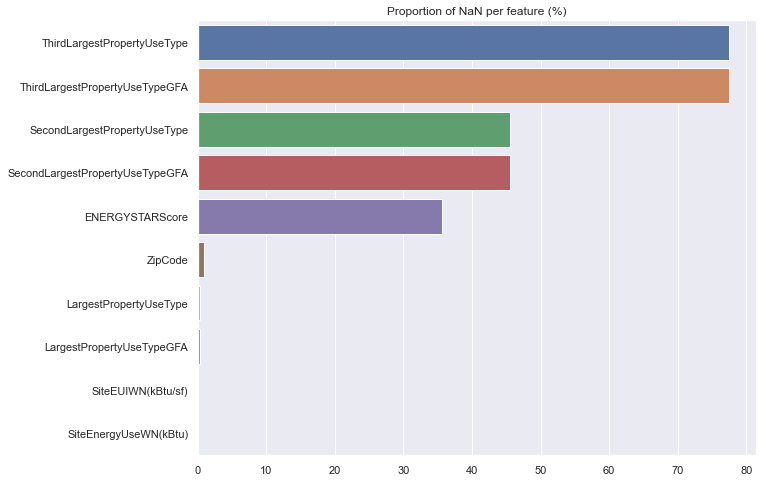

In [32]:
plt.figure(figsize=(10,8))
plt.title('Proportion of NaN per feature (%)')
sns.barplot(x= 100 * data_nan.values / data_v2.shape[0], y=data_nan.index)

___Filling Second/ThirdLargestPropertyUseType___
Before : (1548, 32)
After : (1548, 32)


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,98101.00,7,DOWNTOWN,1927,1.00,12,88434,0,88434,Hotel,88434.00,No use,0.00,No use,0.00,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,249.98,2.83
1,2,NonResidential,Hotel,98101.00,7,DOWNTOWN,1996,1.00,11,103566,15064,88502,Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,295.86,2.86
2,3,NonResidential,Hotel,98101.00,7,DOWNTOWN,1969,1.00,41,956110,196718,759392,Hotel,756493.00,No use,0.00,No use,0.00,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,2089.28,2.19
3,5,NonResidential,Hotel,98101.00,7,DOWNTOWN,1926,1.00,10,61320,0,61320,Hotel,61320.00,No use,0.00,No use,0.00,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,286.43,4.67
4,8,NonResidential,Hotel,98121.00,7,DOWNTOWN,1980,1.00,18,175580,62000,113580,Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,50221,Nonresidential COS,Other,NaN,1,DELRIDGE NEIGHBORHOODS,1982,1.00,1,18261,0,18261,Other - Recreation,18261.00,No use,0.00,No use,0.00,NaN,51.00,56.20,126.00,136.60,932082.12,1025432.12,0.00,185334.70,632362.01,2997.20,299720.00,20.33,1.11
3372,50223,Nonresidential COS,Other,NaN,2,DOWNTOWN,2004,1.00,1,16000,0,16000,Other - Recreation,16000.00,No use,0.00,No use,0.00,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,32.17,2.01
3373,50224,Nonresidential COS,Other,NaN,7,MAGNOLIA / QUEEN ANNE,1974,1.00,1,13157,0,13157,Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,223.54,16.99
3374,50225,Nonresidential COS,Mixed Use Property,NaN,1,GREATER DUWAMISH,1989,1.00,1,14101,0,14101,Other - Recreation,6601.00,Fitness Center/Health Club/Gym,6501.00,Pre-school/Daycare,484.00,NaN,51.00,55.50,105.30,110.80,719471.19,782841.31,0.00,102248.00,348870.18,3706.01,370601.00,22.11,1.57


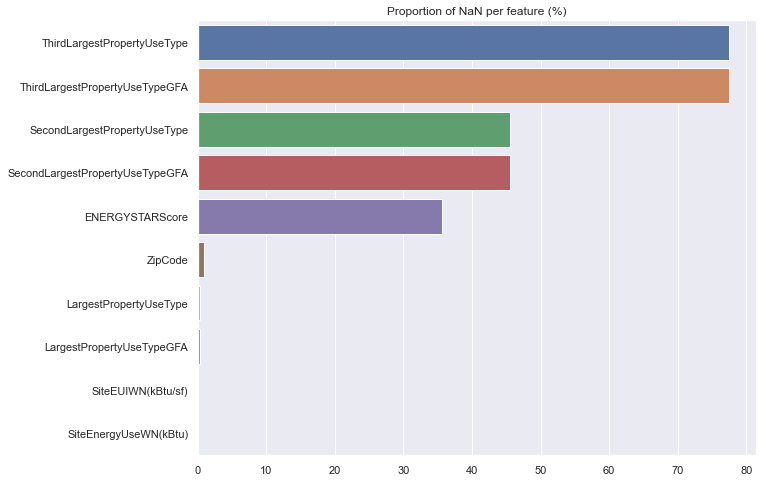

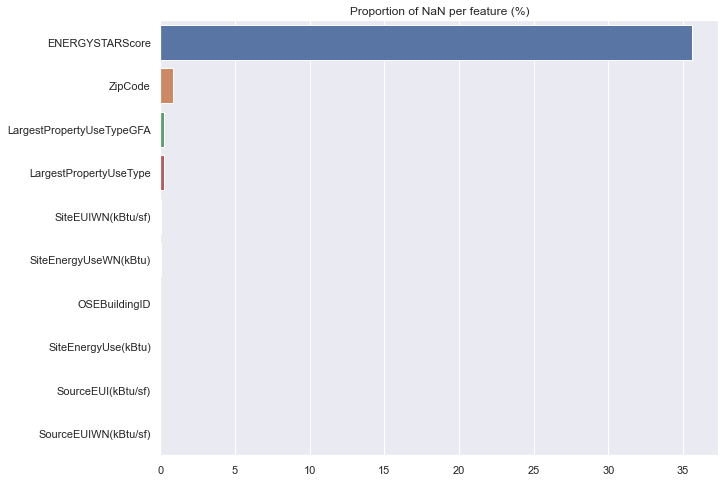

In [33]:
data_v3 = filling_property_use_type(data_v2)

display(data_v3)

We have filled Second and Third Property Use Type GFA by 0 (meaning there are no second or  third use for the building.
We have also filled the Second and Third Property USe Type by "None".

### 5) Removing buildings with NaN values

In [34]:
columns_with_nan = data_v3.columns[data_v3.isna().any()].tolist()
print("These columns have empty values (NaN) :", columns_with_nan, end='\n\n')
print("For the Energy Star Score, we will keep it untouched until later.", end='\n\n')

#x = data_v3[data_v3["ZipCode"].isna()]
#display(x)

#y = data_v3[data_v3["SiteEnergyUseWN(kBtu)"].isna()]
#display(y)

These columns have empty values (NaN) : ['ZipCode', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)']

For the Energy Star Score, we will keep it untouched until later.



In [35]:
features_without_EnergyStarScore = data_v3.columns.tolist()
features_without_EnergyStarScore.remove("ENERGYSTARScore")
print(features_without_EnergyStarScore)

['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


___Dropping buildings with missing values___
Before : (1548, 32)
After cleaning missing values, the file contains 1530 rows et 32 columns.
Remaining missing values : 536
After : (1530, 32)


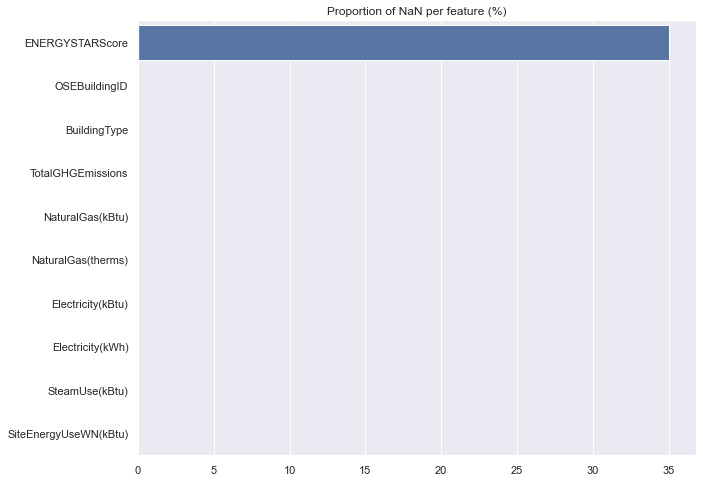

In [36]:
data_v4 = drop_buildings_subset_nan(data_v3, features_without_EnergyStarScore)
display_barplot_na(data_v4, 10)

### 6) Converting datatype and mapping

#### 1) Assign datatype

In [37]:
print("Converting types is done after removing NaN.")

Converting types is done after removing NaN.


In [38]:
data_v5 = assign_type(data_v4)

___Assigning datatype___
Before : OSEBuildingID                        int64
BuildingType                        object
PrimaryPropertyType                 object
ZipCode                            float64
CouncilDistrictCode                  int64
Neighborhood                        object
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA     float64
ENERGYSTARScore                    float64
SiteEUI(kBtu/sf)                   float64
SiteEUIWN(kBtu/sf)                 float64
SourceEUI(kBtu/sf)                 float64
SourceEUIWN(kBtu/sf)

#### 2) Capitalization standardization

In [39]:
data_v6 = capitalize_categorical_variables(data_v5)

print("We have changed the type of the categorical features to 'object'.")

___Capitalization standardization___
Before : (1530, 32)
We capitalize these columns : Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'],
      dtype='object')
We change delridge neighborhoods to delridge manually.
After : (1530, 32)
We have changed the type of the categorical features to 'object'.


#### 3) Transforming building type

In [40]:
data_v7 = transforming_building_type(data_v6)

___Transforming building type___
Before : (1530, 32)
Nonresidential        1427
Nonresidential cos      68
Campus                  24
Sps-district k-12       10
Nonresidential wa        1
Name: BuildingType, dtype: int64
After : (1530, 32)
Nonresidential        1428
Nonresidential cos      68
Campus                  24
Sps-district k-12       10
Name: BuildingType, dtype: int64


### 7) Cleaning negative values

In [41]:
print("We can see that we have negative values for theses features : ")

numeric_columns = data_v7.select_dtypes('number').columns

df_numeric = data_v7.loc[:, [x for x in numeric_columns if x not in ['ENERGYSTARScore']]]
display(df_numeric)

number_negative_values_per_column = df_numeric[df_numeric < 0].count()
display(number_negative_values_per_column.sort_values(ascending=False))

We can see that we have negative values for theses features : 


,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1927,1,12,88434,0,88434,88434.00,0.00,0.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,249.98,2.83
1,1996,1,11,103566,15064,88502,83880.00,15064.00,4622.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,295.86,2.86
2,1969,1,41,956110,196718,759392,756493.00,0.00,0.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,2089.28,2.19
3,1926,1,10,61320,0,61320,61320.00,0.00,0.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,286.43,4.67
4,1980,1,18,175580,62000,113580,123445.00,68009.00,0.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,1929,1,2,24990,0,24990,24990.00,0.00,0.00,176.90,189.30,367.00,378.70,4420650.50,4731813.50,0.00,635119.88,2167029.00,22536.21,2253621.00,134.80,5.39
3340,2013,1,1,72000,0,72000,72000.00,0.00,0.00,40.60,44.40,97.90,101.80,2925780.00,3198858.00,0.00,557332.88,1901620.00,10241.60,1024160.00,67.65,0.94
3347,2015,1,3,45000,0,45000,45728.00,0.00,0.00,29.00,30.60,91.10,96.00,1325972.75,1397742.38,0.00,388620.41,1325973.00,0.00,0.00,9.24,0.21
3356,2015,1,6,345290,85028,260262,151523.00,106498.00,84002.00,144.50,150.80,333.10,335.80,39364116.00,41078600.00,0.00,6927551.00,23636804.00,157273.08,15727308.00,1000.06,2.90


GHGEmissionsIntensity              1
TotalGHGEmissions                  1
Electricity(kBtu)                  1
Electricity(kWh)                   1
SourceEUIWN(kBtu/sf)               1
NumberofBuildings                  0
NaturalGas(kBtu)                   0
NaturalGas(therms)                 0
SteamUse(kBtu)                     0
SiteEnergyUseWN(kBtu)              0
SiteEnergyUse(kBtu)                0
YearBuilt                          0
SiteEUIWN(kBtu/sf)                 0
SiteEUI(kBtu/sf)                   0
ThirdLargestPropertyUseTypeGFA     0
SecondLargestPropertyUseTypeGFA    0
LargestPropertyUseTypeGFA          0
PropertyGFABuilding(s)             0
PropertyGFAParking                 0
PropertyGFATotal                   0
NumberofFloors                     0
SourceEUI(kBtu/sf)                 0
dtype: int64

In [42]:
data_v8 = dropping_negative_values(data_v7)  # removes one building

numeric_columns = data_v8.select_dtypes('number').columns

df_numeric = data_v8.loc[:, [x for x in numeric_columns if x not in ['ENERGYSTARScore']]]
display(df_numeric)

number_negative_values_per_column = df_numeric[df_numeric < 0].count()
display(number_negative_values_per_column.sort_values(ascending=False))

___Dropping buildings with negative values___
Before : (1530, 32)
We have 22 numerical columns without the ENERGYSTARScore.
After : (1529, 32)


,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1927,1,12,88434,0,88434,88434.00,0.00,0.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,249.98,2.83
1,1996,1,11,103566,15064,88502,83880.00,15064.00,4622.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,295.86,2.86
2,1969,1,41,956110,196718,759392,756493.00,0.00,0.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,2089.28,2.19
3,1926,1,10,61320,0,61320,61320.00,0.00,0.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,286.43,4.67
4,1980,1,18,175580,62000,113580,123445.00,68009.00,0.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,1929,1,2,24990,0,24990,24990.00,0.00,0.00,176.90,189.30,367.00,378.70,4420650.50,4731813.50,0.00,635119.88,2167029.00,22536.21,2253621.00,134.80,5.39
3340,2013,1,1,72000,0,72000,72000.00,0.00,0.00,40.60,44.40,97.90,101.80,2925780.00,3198858.00,0.00,557332.88,1901620.00,10241.60,1024160.00,67.65,0.94
3347,2015,1,3,45000,0,45000,45728.00,0.00,0.00,29.00,30.60,91.10,96.00,1325972.75,1397742.38,0.00,388620.41,1325973.00,0.00,0.00,9.24,0.21
3356,2015,1,6,345290,85028,260262,151523.00,106498.00,84002.00,144.50,150.80,333.10,335.80,39364116.00,41078600.00,0.00,6927551.00,23636804.00,157273.08,15727308.00,1000.06,2.90


YearBuilt                          0
NumberofBuildings                  0
TotalGHGEmissions                  0
NaturalGas(kBtu)                   0
NaturalGas(therms)                 0
Electricity(kBtu)                  0
Electricity(kWh)                   0
SteamUse(kBtu)                     0
SiteEnergyUseWN(kBtu)              0
SiteEnergyUse(kBtu)                0
SourceEUIWN(kBtu/sf)               0
SourceEUI(kBtu/sf)                 0
SiteEUIWN(kBtu/sf)                 0
SiteEUI(kBtu/sf)                   0
ThirdLargestPropertyUseTypeGFA     0
SecondLargestPropertyUseTypeGFA    0
LargestPropertyUseTypeGFA          0
PropertyGFABuilding(s)             0
PropertyGFAParking                 0
PropertyGFATotal                   0
NumberofFloors                     0
GHGEmissionsIntensity              0
dtype: int64

### 8) Verifying GFA

In [43]:
verify_PropertyGFA(data_v8)

___Verifying propertyGFATotal___
End of checking.


We have checked that the Total Property GFA is equal to the Total Building(s) GFA + Total Parking GFA.

We display the proportion of NaN per feature for our dataset.

**Analysis** :
- We notice with the barplot below that the Second and Third Largest Property (GFA and Type) have more than 50% of missing values.

- Outliers too is a feature with more than 90% of missing values : that's because if the value is missing it means the building is not an outlier.

### 9) Computing Total Energy

We consider that the **Total Energy** of a building is represented by the variable **SiteEnergyUse(kBtu)**.
Thus  **SiteEnergyUse(kBtu)** = **Electricity(kBtu)** + **SteamUse(kBtu)** + **NaturalGas(kBtu)** + **OtherEnergy(kBtu)**

We will compute the difference between the Total Energy and Electricity(kBtu) + SteamUse(kBtu) + NaturalGas(kBtu) and if the difference / error / other energy is greater than 1% we drop the building.

In [44]:
print("The computed remaining energy is the absolute value of the percentage of total energy that remaining energy has.")
print("The computation of the remaining energy is based on a hypothesis that the site energy is the sum of electricity, steam and natural gas.")

data_v9 = compute_total_energy(data_v8)#.sort_values(by="RemainingEnergy(%)", ascending=False)

The computed remaining energy is the absolute value of the percentage of total energy that remaining energy has.
The computation of the remaining energy is based on a hypothesis that the site energy is the sum of electricity, steam and natural gas.
___Computing Total Energy___
Before : (1529, 32)


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,RemainingEnergy(kBtu),RemainingEnergy(%)
0,1,Nonresidential,Hotel,98101.0,7,Downtown,1927,1,12,88434,0,88434,Hotel,88434.00,No use,0.00,No use,0.00,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,249.98,2.83,0.50,0.00
1,2,Nonresidential,Hotel,98101.0,7,Downtown,1996,1,11,103566,15064,88502,Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,295.86,2.86,0.00,0.00
2,3,Nonresidential,Hotel,98101.0,7,Downtown,1969,1,41,956110,196718,759392,Hotel,756493.00,No use,0.00,No use,0.00,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,2089.28,2.19,6.00,0.00
3,5,Nonresidential,Hotel,98101.0,7,Downtown,1926,1,10,61320,0,61320,Hotel,61320.00,No use,0.00,No use,0.00,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,286.43,4.67,0.75,0.00
4,8,Nonresidential,Hotel,98121.0,7,Downtown,1980,1,18,175580,62000,113580,Hotel,123445.00,Parking,68009.00,Swimming pool,0.00,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,505.01,2.88,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,50069,Nonresidential,Small- and mid-sized office,98108.0,2,Greater duwamish,1929,1,2,24990,0,24990,Office,24990.00,No use,0.00,No use,0.00,9.00,176.90,189.30,367.00,378.70,4420650.50,4731813.50,0.00,635119.88,2167029.00,22536.21,2253621.00,134.80,5.39,0.50,0.00
3340,50070,Nonresidential,Other,98155.0,4,Northeast,2013,1,1,72000,0,72000,Other - recreation,72000.00,No use,0.00,No use,0.00,NaN,40.60,44.40,97.90,101.80,2925780.00,3198858.00,0.00,557332.88,1901620.00,10241.60,1024160.00,67.65,0.94,0.00,0.00
3347,50081,Nonresidential,K-12 school,98144.0,3,Greater duwamish,2015,1,3,45000,0,45000,K-12 school,45728.00,Parking,0.00,No use,0.00,77.00,29.00,30.60,91.10,96.00,1325972.75,1397742.38,0.00,388620.41,1325973.00,0.00,0.00,9.24,0.21,-0.25,0.00
3356,50094,Nonresidential,Mixed use property,98109.0,7,Lake union,2015,1,6,345290,85028,260262,Laboratory,151523.00,Office,106498.00,Parking,84002.00,NaN,144.50,150.80,333.10,335.80,39364116.00,41078600.00,0.00,6927551.00,23636804.00,157273.08,15727308.00,1000.06,2.90,4.00,0.00


Shape : (1529, 34)
After : (1508, 32)


#### 10) Computing YearBuilt

In [45]:
print("The year in which the building was built is a categorical variables."
      "In order to use this feature properly, we compute the years that passed since the building was built. We have now a numerical feature to express the YearBuilt variable.")

The year in which the building was built is a categorical variables.In order to use this feature properly, we compute the years that passed since the building was built. We have now a numerical feature to express the YearBuilt variable.


In [46]:
data_v10 = compute_YearBuilt(data_v9)

today = datetime.date.today()
year = today.year
print(year, type(year))

display(data_v10[["YearSinceBuilt", "YearBuilt"]])

___Computing the years since the buildings were built___
Before : (1508, 32)
After : (1508, 33)
2022 <class 'int'>


,YearSinceBuilt,YearBuilt
0,95,1927
1,26,1996
2,53,1969
3,96,1926
4,42,1980
...,...,...
3339,93,1929
3340,9,2013
3347,7,2015
3356,7,2015


### Saving final cleaned dataset

In [47]:
# We reset the index
data_v10 = data_v10.reset_index(drop = True)

# Save
export_path = "./dataset/cleaned/"
export_filename = "data_cleaned.csv"

data_v10.to_csv("{}{}".format(export_path, export_filename), index=False)

In [48]:
# End of pipeline time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))

computing time : 8.168229 sec
computing time : 00:00:08
